## Requirements for this notebook
#### Within Python
- Jupyter notebook
- numpy
- numba
- pandas
- seaborn
- matplotlib
#### Other
- bcftools

In [1]:
import numpy as np
import pandas as pd
import numba
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Function definitions

In [2]:
def load_true_la(path):
    """Load true local ancestry."""
    return(np.load(path)['arr'])


def get_true_anc_dosage(true_la, n_anc):
    """Compute true local ancestry dosage from the true local ancestry array.
    Should be in int8 dtype."""
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1] / 2 * n_anc)), dtype='int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1] / 2 * n_anc)), dtype='int8')
    aa = np.arange(true_la[:, ::2].shape[1]) * n_anc + true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1]) * n_anc + true_la[:, 1::2]
    np.put_along_axis(hap1, aa.astype('int'), 1, axis=1)
    np.put_along_axis(hap2, bb.astype('int'), 1, axis=1)
    return(hap1 + hap2)


def get_ancestry_dosage(arr, n_anc):
    """Compute ancestry dosage from probablistic haploid ancestry calls.
    The shape of the returned array is:
    ncols = (number of inds) * (number of ancestries)
    nrow = number of sites
    
    Order of the columns, assuming 0-based indexing:
    [ind0anc0, ind0anc1, ind0anc2, ind1anc0, ...] for n_anc=3
    
    This function produces np.floats by default, 
    but these are converted within the r2 computation. 
    """
    
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1] / 2)))
    if n_anc == 2:
        a0 = arr[:, 0::2]  # should be views
        a1 = arr[:, 1::2]
        anc_dosage[:, 0::2] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::2] = a1[:, ::2] + a1[:, 1::2]
    if n_anc == 3:
        a0 = arr[:, 0::3]
        a1 = arr[:, 1::3]
        a2 = arr[:, 2::3]
        anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    elif n_anc == 4:
        a0 = arr[:, 0::4]
        a1 = arr[:, 1::4]
        a2 = arr[:, 2::4]
        a3 = arr[:, 3::4]
        anc_dosage[:, 0::4] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::4] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::4] = a2[:, ::2] + a2[:, 1::2]
        anc_dosage[:, 3::4] = a3[:, ::2] + a3[:, 1::2]
    return(anc_dosage)


def r2_dosage_ancestry(true_dosage, pred_dosage, n_anc):
    """Get ancestry-specific R2 values for LA vs truth.
    Returns a list with one R2 per ancestry."""
    per_anc = []
    for i in range(n_anc):
        per_anc.append(
            pearsonr2_numba(
                true_dosage[:, i::n_anc].reshape(-1),
                pred_dosage[:, i::n_anc].reshape(-1),
            )
        )
    return(per_anc)


@numba.jit(
    numba.float64(
        numba.float32[:],
        numba.float32[:],
    ),
    nopython=True
)
def pearsonr2_numba(x, y):
    """Return the *squared* pearson correlation coef.
    x and y are not modified.
    Input arrays should be np.float32, output is a single float64 value.
    Return and intermediate values maintained as float64 due to precision issues. 
    """
    assert len(x) == len(y)
    # return Nan if either x or y is constant
    if (x == x[0]).all() or (y == y[0]).all():
        return(np.nan)

    n = len(x)
    # mean of x and y
    xmean = numba.float64(0.0)
    ymean = numba.float64(0.0)
    for i in range(n):
        xmean += x[i]
        ymean += y[i]
    xmean = xmean / n
    ymean = ymean / n

    r_num = numba.float64(0.0)
    r_dena = numba.float64(0.0)
    r_denb = numba.float64(0.0)
    for i in range(n):
        xd = x[i] - xmean  # difference from the mean
        yd = y[i] - ymean
        r_num += xd * yd
        r_dena += xd * xd
        r_denb += yd * yd
    r2 = (r_num * r_num) / (r_dena * r_denb)
    return(r2)


def convert_flare_vcf(flare_vcf, flare_csv, flare_sites, BCFTOOLS):
    """Convert the vcf created by flare (with "probs=true") into a csv file. 
    The csv file will be located at the path given by @flare_csv.
    It contains 1 column per haploid*ancestry, 1 row per site.
    Values are the ANP1 and ANP2 values from flare, which have one sub-value per ancestry.
    
    All values are comma-delimited.  
    First column: chrID
    Second coluomn: site pos in bp
    Subsequent columns: ANP value for a specific haploid and ancestry
    
    
    Notice the ANP values are in increments of 0.01, so 101 possible values [0, 0.01, ... 0.99, 1]
    
    Also produces a file at @flare_sites that has one line per site included in the falre output. 
    This file is used to match the flare output with the true LA 
    if some sites present in the true output are not included in the flare output, 
    perhaps due to a minor allele count or minor allele frequency filter applied by flare.
    
    Uses bcftools to generate the ouput, so @BCFTOOLS should be a path to a working bcftools executable. """
    
    os.system(f"{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\\n' {flare_vcf} > {flare_csv} ")

    os.system(f"{BCFTOOLS} query -f '%POS\n' {flare_vcf} > {flare_sites} ")
        

def load_flare(path, sites_file, flare_sites, BCFTOOLS):
    """Load an array of the posterior local ancestry probabilities from flare."""
    flare = pd.read_csv(path, header=None)
    flare = flare.dropna(axis=1)
    res = flare.iloc[:, 2:].values # remove the first two columns holding chrID and site pos. 
    res = np.concatenate([res[:1], res])

    # account for any sites filtered by flare (e.g. due to MAF)
    pre_sites = pd.read_csv(sites_file, header=None).values.flatten()
    post_sites = pd.read_csv(flare_sites, header=None).values.flatten()
    post_indexes = np.searchsorted(post_sites, pre_sites)
    del pre_sites, post_sites
    res = res[post_indexes]

    return(res)


def plot_ancestry_dosage(
    pred_dosage, # 
    start_index, # how far to index into the dosage arrays, 
    n_anc, # number of ancestries
    title, # string - will be include at the top of the plot
    path=None, # if this specified, the plot with be saved here
    format='pdf', # save format, can also be e.g. "png" to produce non vector graphics. 
    reference_dosage=None # if this is specified, this will show up as a dashed line
    ):
    """
    Produce a plot tracking the predicted dosage for each ancestry along the genome.
    The true ancestry can also be include as dashed line. 
    
    For the plot to make sense @start_index should be =  (ind counter) * (n_anc-1)
    So for the first ind (individual 0) the start index should be 0.  
    For the second ind (individual 1) the start index should be equal to n_anc-1 
    """
    
    # colors to use for the ancestries, only works up to 4
    colors = ['blue', 'orange', 'green', 'purple']

    # size and layout of the figure
    fig, ax = plt.subplots(
        figsize=(24, n_anc * 2.5),
        nrows=n_anc,
        sharex=True,
        sharey=True
    )
    f = []
    for i in range(n_anc):
        l, = ax[i].plot(pred_dosage[:, start_index + i], c=colors[i], alpha=.9, lw = 4)
        f.append(l)
        if reference_dosage is not None:
            l, = ax[i].plot(
                reference_dosage[:, start_index + i], c=colors[i], alpha=.5, ls='--', lw=2
            )
            ax[i].set_ylabel('dosage') 

    plt.legend(f, [f'pop{p}' for p in range(n_anc)])

    fig.tight_layout()
    sns.despine(bottom=True)
    ax[0].set_title(title)
    ax[-1].set_xlabel('Site number ')
    if path:
        plt.savefig(path, dpi=300, format=format, bbox_inches='tight')

# setup

In [3]:
n_anc = 2 #should be an integer giving the number of ancestries
BCFTOOLS = '/home/kele/Documents/lai/lai-sim/programs/bcftools-1.16/bcftools'

In [4]:
!mkdir 'work'

mkdir: cannot create directory ‘work’: File exists


In [5]:
# paths to input files
true_la_path = 'true_local_ancestry.site_matrix.npz' # string with path to the npz file giving true ancestry 
sites_file = 'site.positions' # path to a file that has one line per site in the true local ancestry data
flare_vcf = 'flare/flare.anc.vcf.gz' # path to the *.vcf.gz output from flare.

In [6]:
# output and intermediate files
# these will be created during executing this 
R2_path = 'work/R2.txt' # string giving path to the file to put the R2 output
flare_sites = 'work/flare.anc.flare_sites'
flare_csv = 'work/flare.csv'
true_dosage_path = 'work/true.dosage.npz'
flare_dosage_path = 'work/flare.dosage.npz'

In [7]:
# create flare_csv and flare_sites files
convert_flare_vcf(
    flare_vcf=flare_vcf,
    flare_csv=flare_csv,
    flare_sites=flare_sites,
    BCFTOOLS=BCFTOOLS)

In [8]:
# load the local ancestry calls from flare and the true local ancestry.
flare_la = load_flare(
    path=flare_csv,
    sites_file=sites_file,
    flare_sites=flare_sites,
    BCFTOOLS=BCFTOOLS )

true_la = load_true_la(true_la_path)

# these are different shapes
# they are in different formats as the flare results are storing probabilistic LA calls
# while the true data only stores the true calls
true_la.shape, flare_la.shape

((309527, 200), (309527, 400))

In [9]:
flare_la

array([[0.  , 1.  , 0.  , ..., 1.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , ..., 1.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , ..., 1.  , 0.  , 1.  ],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.05, 0.95],
       [1.  , 0.  , 0.  , ..., 0.  , 0.05, 0.95],
       [1.  , 0.  , 0.  , ..., 0.  , 0.05, 0.95]])

In [10]:
# get the ancestry dosage
# also convert to the dtype that is required by the numba-decorated function
true_dosage = get_true_anc_dosage(true_la, n_anc).astype(np.float32)
flare_dosage = get_ancestry_dosage(flare_la, n_anc).astype(np.float32)
true_dosage.shape, flare_dosage.shape

((309527, 200), (309527, 200))

In [11]:
true_dosage.dtype, flare_dosage.dtype

(dtype('float32'), dtype('float32'))

In [12]:
np.savez_compressed(true_dosage_path, true_dosage)
np.savez_compressed(flare_dosage_path, flare_dosage)

In [13]:
r2_dosage_ancestry(
    true_dosage=true_dosage, 
    pred_dosage=flare_dosage,
    n_anc=n_anc)

[0.9870607875917546, 0.9870607887857137]

In [35]:
# alternate test implementation using np.corrcoef
# should provide very similar results, with some small difference possible (<1e-4)

In [37]:
def r2_dosage_ancestry_CORR(true_dosage, pred_dosage, n_anc):
    """Get ancestry-specific R2 values for LA vs truth.
    Returns a list with one R2 per ancestry."""
    per_anc = []
    for i in range(n_anc):
        per_anc.append(
            np.corrcoef(
                true_dosage[:, i::n_anc].reshape(-1),
                pred_dosage[:, i::n_anc].reshape(-1),
            )[0,1]**2
        )
    return(per_anc)

In [44]:
r2_dosage_ancestry_CORR(
    true_dosage=true_dosage, 
    pred_dosage=flare_dosage,
    n_anc=n_anc)

[0.9870607877195956, 0.9870607873277016]

# The speedup doesn't matter here so much but is more meaningful in the larger analyses. 

In [42]:
%%timeit
r2_dosage_ancestry(
    true_dosage=true_dosage, 
    pred_dosage=flare_dosage,
    n_anc=n_anc)

260 ms ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit
r2_dosage_ancestry_CORR(
    true_dosage=true_dosage, 
    pred_dosage=flare_dosage,
    n_anc=n_anc)

652 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot of local ancestry dosage. 
Each solid line is the inferred local ancestry dosage at each site in the genome.
The dashed lines give the true local ancestry dosage at each site.
Each ancestry is plotted a separate y-axis shown on the left.
The very small vertical changes in true local ancestry are likely due to gene conversion. 

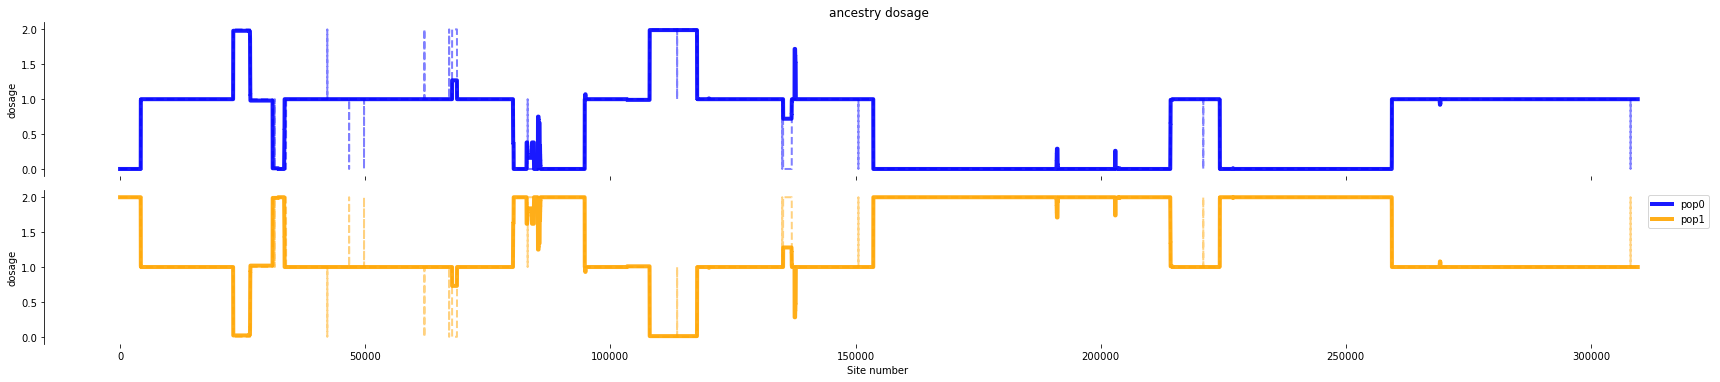

In [48]:
plot_ancestry_dosage(
	pred_dosage=flare_dosage,
	start_index=0,
	n_anc=2,
    title='ancestry dosage',
	reference_dosage=true_dosage,
    path=None, # if this specified, the plot with be saved here
    format='pdf',
)